In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/acoustic-extinguisher-fire-dataset/Acoustic_Extinguisher_Fire_Dataset.xlsx


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

file_path = '/kaggle/input/acoustic-extinguisher-fire-dataset/Acoustic_Extinguisher_Fire_Dataset.xlsx'

data = pd.read_excel(file_path, sheet_name="A_E_Fire_Dataset")

print(data.head())
print(data.info())


   SIZE      FUEL  DISTANCE  DESIBEL  AIRFLOW  FREQUENCY  STATUS
0     1  gasoline        10       96      0.0         75       0
1     1  gasoline        10       96      0.0         72       1
2     1  gasoline        10       96      2.6         70       1
3     1  gasoline        10       96      3.2         68       1
4     1  gasoline        10      109      4.5         67       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB
None


In [ ]:
le = LabelEncoder()
data['FUEL'] = le.fit_transform(data['FUEL'])

X = data.drop(columns=['STATUS'])
y = data['STATUS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, rf_preds))

xgb_model = xgb.XGBClassifier(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost Report:\n", classification_report(y_test, xgb_preds))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1752
           1       0.97      0.96      0.96      1737

    accuracy                           0.96      3489
   macro avg       0.96      0.96      0.96      3489
weighted avg       0.96      0.96      0.96      3489

XGBoost Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1752
           1       0.98      0.97      0.98      1737

    accuracy                           0.98      3489
   macro avg       0.98      0.98      0.98      3489
weighted avg       0.98      0.98      0.98      3489



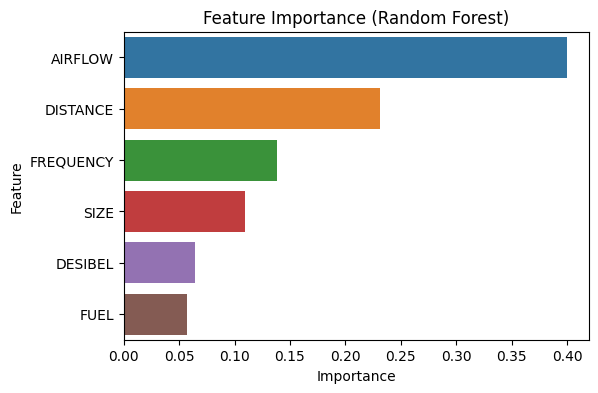

In [5]:
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=feat_imp, x='Importance', y='Feature')
plt.title("Feature Importance (Random Forest)")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dnn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

dnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train Model
history = dnn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate
dnn_preds = (dnn_model.predict(X_test_scaled) > 0.5).astype("int32")
print("DNN Classification Report:\n", classification_report(y_test, dnn_preds))


2025-08-25 09:26:50.325416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756114010.586909      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756114010.661085      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-25 09:27:06.904434: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8050 - loss: 0.4176 - val_accuracy: 0.8942 - val_loss: 0.2275
Epoch 2/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9039 - loss: 0.2222 - val_accuracy: 0.9074 - val_loss: 0.2017
Epoch 3/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9151 - loss: 0.2036 - val_accuracy: 0.9117 - val_loss: 0.1929
Epoch 4/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9141 - loss: 0.1952 - val_accuracy: 0.9180 - val_loss: 0.1817
Epoch 5/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9194 - loss: 0.1944 - val_accuracy: 0.9240 - val_loss: 0.1747
Epoch 6/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9244 - loss: 0.1795 - val_accuracy: 0.9258 - val_loss: 0.1667
Epoch 7/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9276 - loss: 0.1737 - val_accuracy: 0.9309 - val_loss: 0.1630
Epoch 8/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9287 - loss: 0.1653 - val_accuracy: 0.9344 - val_

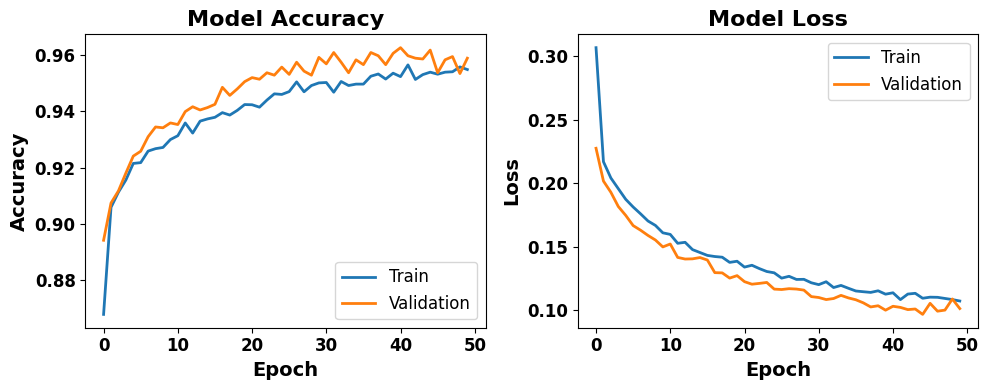

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.title('Model Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(fontsize=12)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.title('Model Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


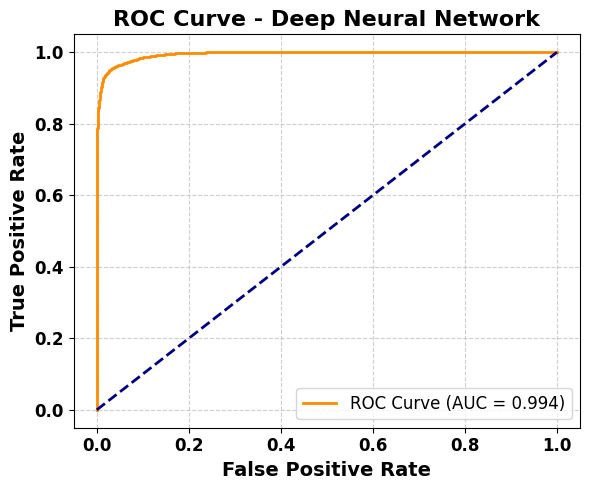

In [ ]:
from sklearn.metrics import roc_curve, auc

y_probs = dnn_model.predict(X_test_scaled).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('ROC Curve - Deep Neural Network', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


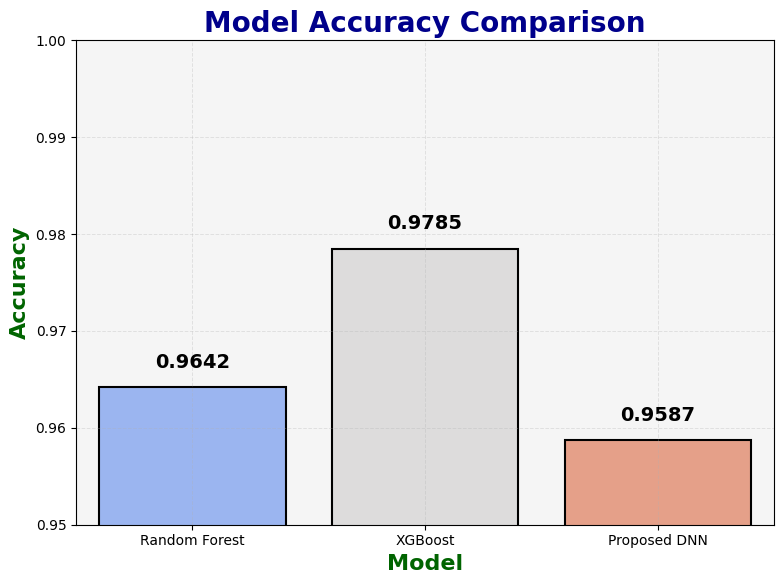

In [ ]:
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation

rf_acc = accuracy_score(y_test, rf_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)
dnn_acc = accuracy_score(y_test, dnn_preds)

acc_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Proposed DNN'],
    'Accuracy': [rf_acc, xgb_acc, dnn_acc]
})

fig, ax = plt.subplots(figsize=(8, 6))

sns.set(style="whitegrid")
bars = sns.barplot(data=acc_df, x='Model', y='Accuracy', palette='coolwarm', edgecolor='black', ax=ax)

plt.title('Model Accuracy Comparison', fontsize=20, fontweight='bold', color='darkblue', loc='center')
plt.xlabel('Model', fontsize=16, fontweight='bold', color='darkgreen')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold', color='darkgreen')

for i, val in enumerate(acc_df['Accuracy']):
    bars.text(i, val + 0.002, f"{val:.4f}", ha='center', fontsize=14, fontweight='bold', color='black')

for bar in bars.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.5)

def animate_bars(i):
    for j, bar in enumerate(bars.patches):
        bar.set_height(np.random.uniform(0.95, acc_df['Accuracy'][j]))
    return bars.patches

ani = FuncAnimation(fig, animate_bars, frames=30, repeat=False, interval=100)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.3)
ax.set_facecolor('whitesmoke')

plt.ylim(0.95, 1.0)
plt.tight_layout()

plt.show()


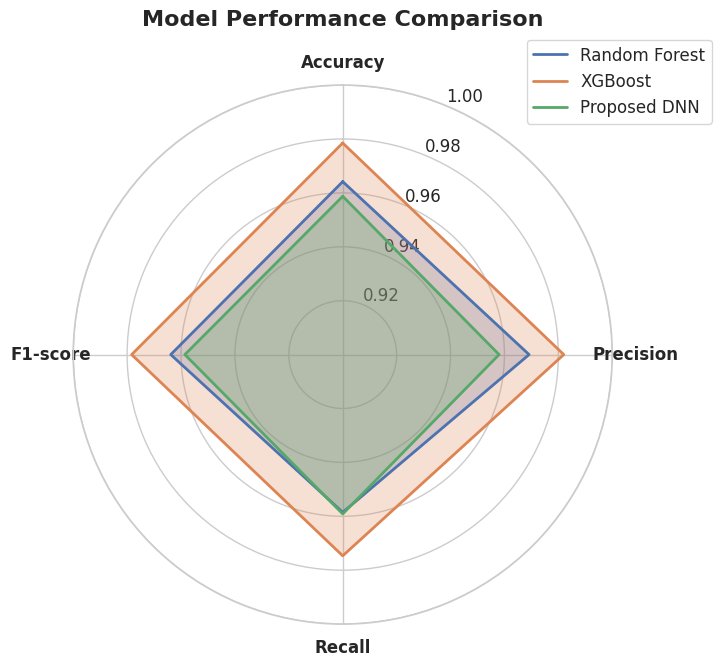

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

rf_metrics = [
    accuracy_score(y_test, rf_preds),
    precision_score(y_test, rf_preds),
    recall_score(y_test, rf_preds),
    f1_score(y_test, rf_preds)
]

xgb_metrics = [
    accuracy_score(y_test, xgb_preds),
    precision_score(y_test, xgb_preds),
    recall_score(y_test, xgb_preds),
    f1_score(y_test, xgb_preds)
]

dnn_metrics = [
    accuracy_score(y_test, dnn_preds),
    precision_score(y_test, dnn_preds),
    recall_score(y_test, dnn_preds),
    f1_score(y_test, dnn_preds)
]

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

rf_metrics += rf_metrics[:1]
xgb_metrics += xgb_metrics[:1]
dnn_metrics += dnn_metrics[:1]
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

ax.plot(angles, rf_metrics, linewidth=2, linestyle='solid', label='Random Forest')
ax.fill(angles, rf_metrics, alpha=0.25)

ax.plot(angles, xgb_metrics, linewidth=2, linestyle='solid', label='XGBoost')
ax.fill(angles, xgb_metrics, alpha=0.25)

ax.plot(angles, dnn_metrics, linewidth=2, linestyle='solid', label='Proposed DNN')
ax.fill(angles, dnn_metrics, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=14, fontweight='bold')
ax.set_ylim(0.9, 1.0)  # Zoom into high performance
ax.tick_params(axis='both', labelsize=12)
plt.title("Model Performance Comparison", fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=12)

plt.show()


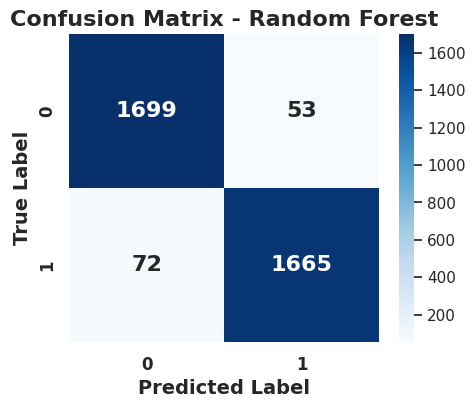

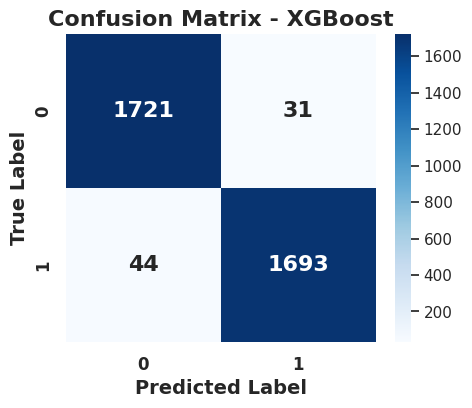

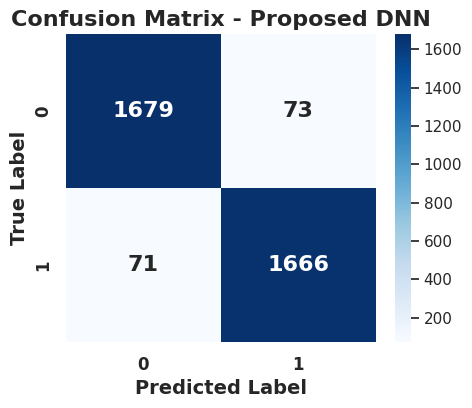

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                annot_kws={"size":16, "weight":"bold"})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.show()

plot_confusion_matrix(y_test, rf_preds, "Confusion Matrix - Random Forest")

plot_confusion_matrix(y_test, xgb_preds, "Confusion Matrix - XGBoost")

plot_confusion_matrix(y_test, dnn_preds, "Confusion Matrix - Proposed DNN")


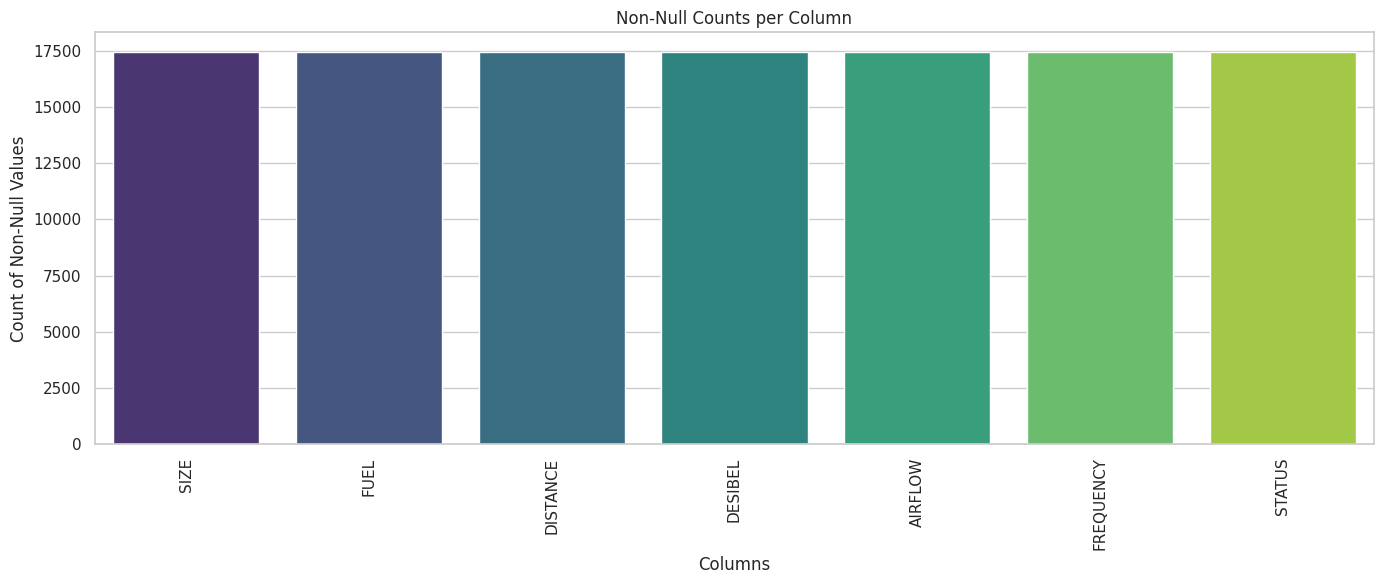

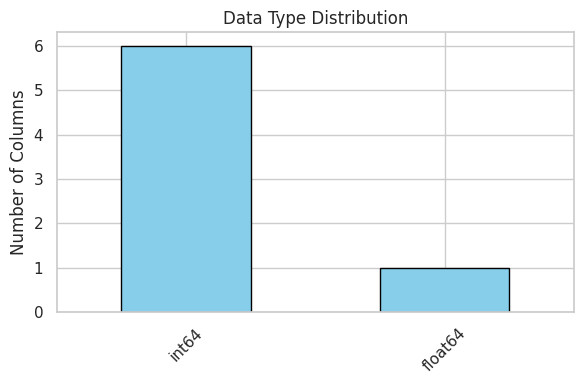

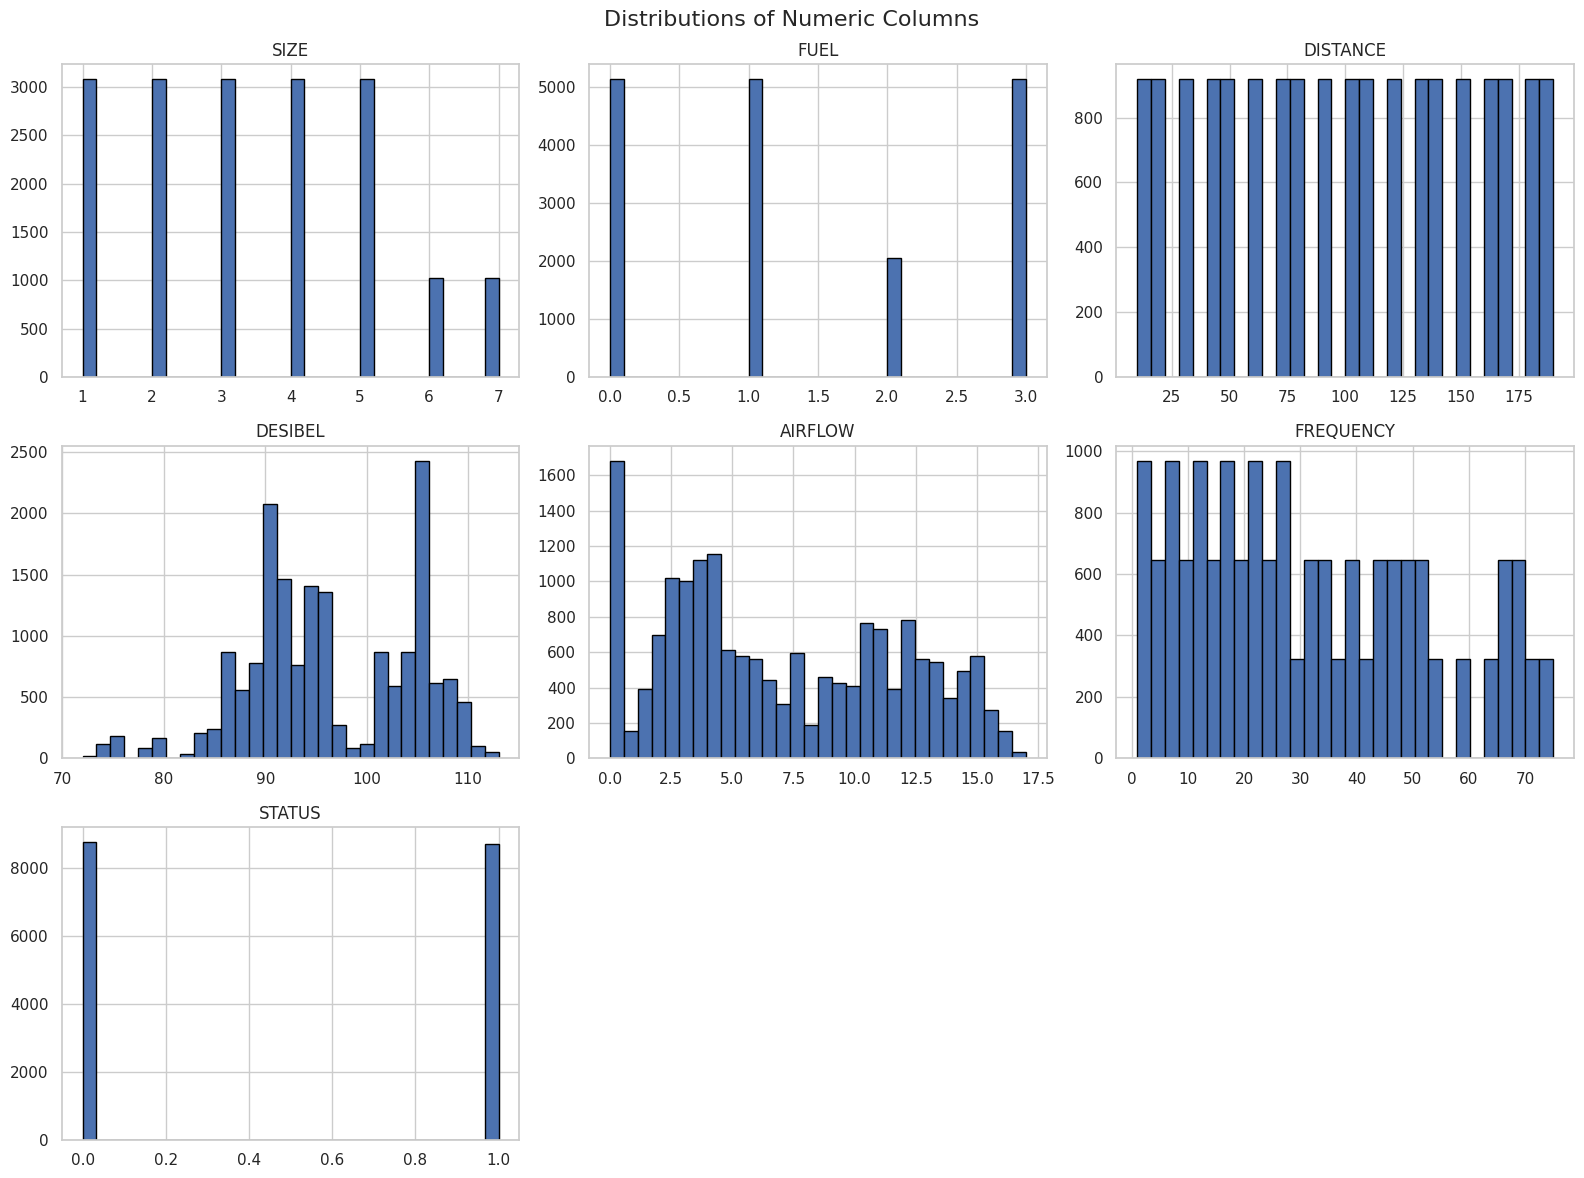

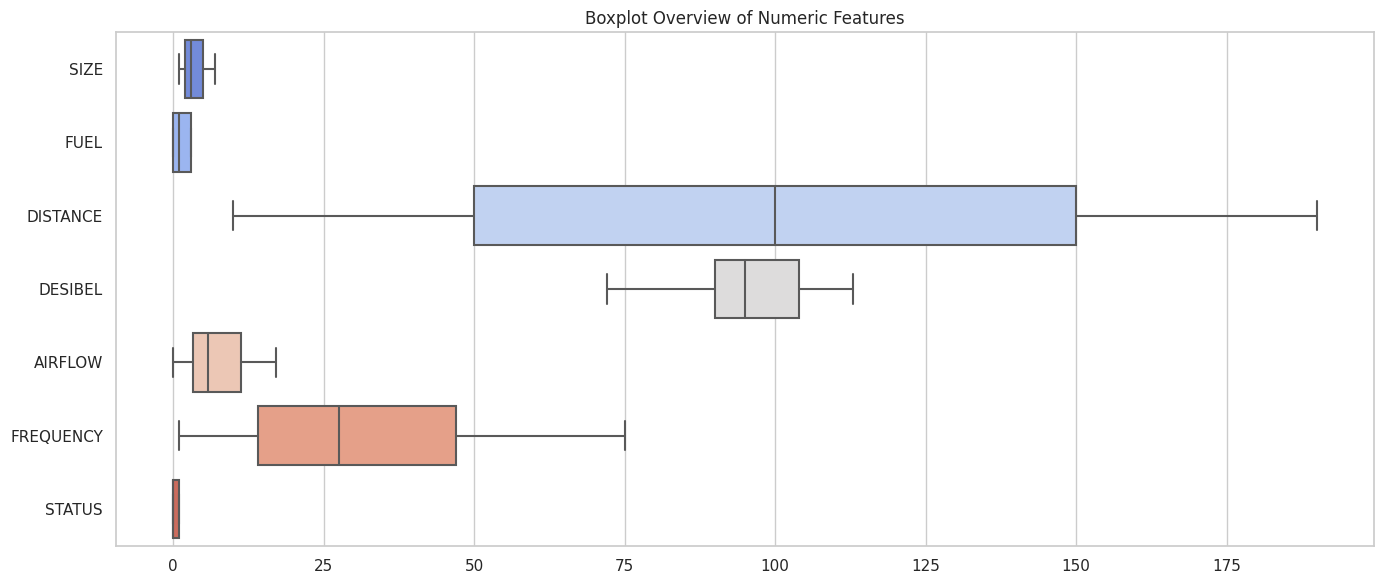

In [ ]:
import os

save_dir = "figures"
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(14, 6))
sns.barplot(x=data.columns, y=data.notnull().sum(), palette="viridis")
plt.xticks(rotation=90)
plt.title("Non-Null Counts per Column")
plt.ylabel("Count of Non-Null Values")
plt.xlabel("Columns")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "non_null_counts.png"), dpi=300)
plt.show()

dtype_counts = data.dtypes.value_counts()
plt.figure(figsize=(6, 4))
dtype_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Data Type Distribution")
plt.ylabel("Number of Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "data_type_distribution.png"), dpi=300)
plt.show()

num_cols = data.select_dtypes(include=np.number).columns
ax = data[num_cols].hist(figsize=(16, 12), bins=30, edgecolor="black")
plt.suptitle("Distributions of Numeric Columns", size=16)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "numeric_distributions.png"), dpi=300)
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=data[num_cols], orient="h", palette="coolwarm")
plt.title("Boxplot Overview of Numeric Features")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "numeric_boxplots.png"), dpi=300)
plt.show()


In [ ]:
import plotly.express as px

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig = px.bar(
    feat_imp,
    x='Importance',
    y='Feature',
    orientation='h',
    title="<b>Random Forest Feature Importance</b>",
    color='Importance',
    color_continuous_scale="Plasma"
)
fig.update_layout(
    title_font=dict(size=22, family="Arial Black"),
    xaxis=dict(tickfont=dict(size=14, family="Arial Black")),
    yaxis=dict(tickfont=dict(size=14, family="Arial Black"))
)
fig.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff

cm = confusion_matrix(y_test, rf_preds)
labels = np.unique(y_test)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=[str(x) for x in labels],
    y=[str(x) for x in labels],
    colorscale="Viridis",
    showscale=True
)
fig.update_layout(
    title="<b>Confusion Matrix (Random Forest)</b>",
    title_font=dict(size=22, family="Arial Black"),
    xaxis=dict(title="Predicted", tickfont=dict(size=14, family="Arial Black")),
    yaxis=dict(title="Actual", tickfont=dict(size=14, family="Arial Black"))
)
fig.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score, f1_score, accuracy_score
)
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.decomposition import PCA

try:
    import shap
    _has_shap = True
except Exception:
    _has_shap = False

In [16]:
if 'X_test_scaled' not in globals():
    if 'scaler' not in globals():
        scaler = StandardScaler().fit(X_train)
    X_test_scaled = scaler.transform(X_test)

In [17]:
def _get_probs(model, X, is_dnn=False):
    """Return class probabilities for positive class (binary) or full proba (multiclass)."""
    if is_dnn:
        p = model.predict(X, verbose=0)
        return p.ravel() if p.ndim == 2 and p.shape[1] == 1 else p
    # classical estimators
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        return p[:, 1] if p.ndim == 2 and p.shape[1] == 2 else p
    if hasattr(model, "decision_function"):
        # map decision_function to [0,1] with a logistic transform for curves
        z = model.decision_function(X).astype(float)
        return 1/(1+np.exp(-z))
    raise RuntimeError("Model has neither predict_proba nor decision_function.")


In [18]:
y_true = np.asarray(y_test)
classes_ = np.unique(y_true)
is_binary = (len(classes_) == 2)

# Recompute predictions deterministically (does not change prior results)
rf_probs  = _get_probs(rf_model,  X_test, is_dnn=False)
xgb_probs = _get_probs(xgb_model, X_test, is_dnn=False)
dnn_probs = _get_probs(dnn_model, X_test_scaled, is_dnn=True)

rf_preds  = (rf_probs  >= 0.5).astype(int) if is_binary else np.argmax(rf_probs,  axis=1)
xgb_preds = (xgb_probs >= 0.5).astype(int) if is_binary else np.argmax(xgb_probs, axis=1)
dnn_preds = (dnn_probs >= 0.5).astype(int) if is_binary else np.argmax(dnn_probs, axis=1)

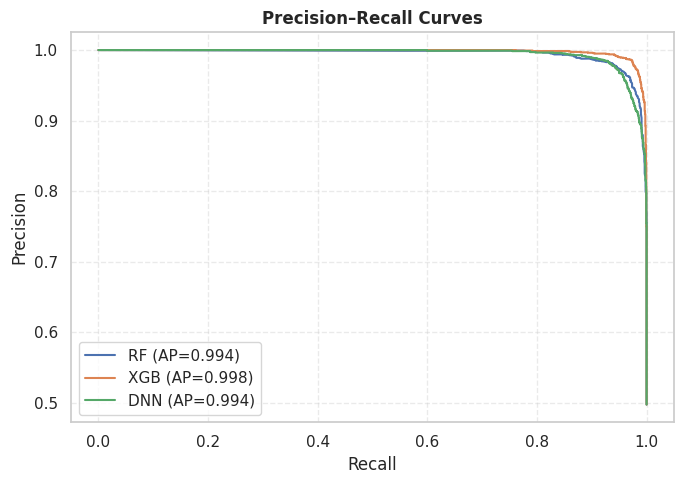

In [19]:
plt.figure(figsize=(7,5))
if is_binary:
    precision, recall, _ = precision_recall_curve(y_true, rf_probs)
    ap = average_precision_score(y_true, rf_probs)
    plt.plot(recall, precision, label=f"RF (AP={ap:.3f})")

    precision, recall, _ = precision_recall_curve(y_true, xgb_probs)
    ap = average_precision_score(y_true, xgb_probs)
    plt.plot(recall, precision, label=f"XGB (AP={ap:.3f})")

    precision, recall, _ = precision_recall_curve(y_true, dnn_probs)
    ap = average_precision_score(y_true, dnn_probs)
    plt.plot(recall, precision, label=f"DNN (AP={ap:.3f})")
else:
    # one-vs-rest micro-average for multiclass
    Y = label_binarize(y_true, classes=classes_)
    for name, probs in [("RF", rf_probs), ("XGB", xgb_probs), ("DNN", dnn_probs)]:
        # micro-average
        precision, recall, _ = precision_recall_curve(Y.ravel(), probs.ravel())
        ap = average_precision_score(Y, probs, average="micro")
        plt.plot(recall, precision, label=f"{name} micro-avg (AP={ap:.3f})")

plt.title("Precision–Recall Curves", fontweight='bold')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout(); plt.show()

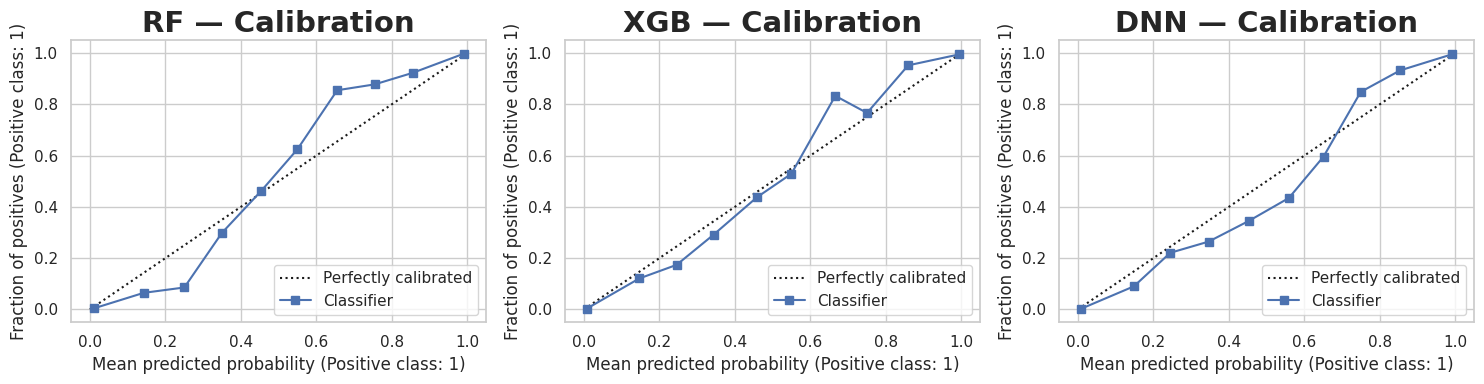

In [20]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

fig, axes = plt.subplots(1, 3, figsize=(15,4))
CalibrationDisplay.from_predictions(y_true, rf_probs, n_bins=10, ax=axes[0]); axes[0].set_title("RF — Calibration", fontweight='bold', fontsize=21)
CalibrationDisplay.from_predictions(y_true, xgb_probs, n_bins=10, ax=axes[1]); axes[1].set_title("XGB — Calibration", fontweight='bold', fontsize=21)
CalibrationDisplay.from_predictions(y_true, dnn_probs, n_bins=10, ax=axes[2]); axes[2].set_title("DNN — Calibration", fontweight='bold', fontsize=21)
plt.tight_layout(); plt.show()

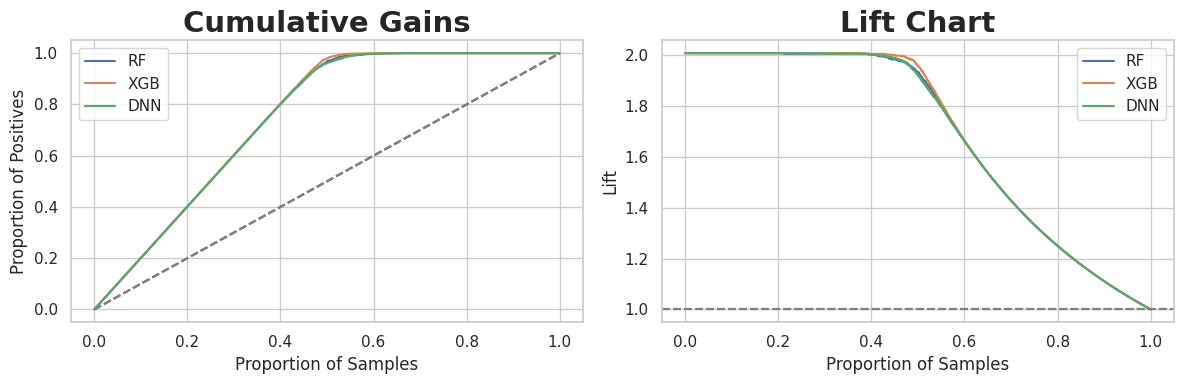

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def cumulative_gains_lift(ax1, ax2, y_true, y_prob, label):
    order = np.argsort(-y_prob)
    y_sorted = y_true[order]
    positives = (y_sorted == classes_[1]) if is_binary else (y_sorted == classes_[-1])
    cum_positives = np.cumsum(positives)
    total_pos = positives.sum()
    n = len(y_true)
    perc_samples = np.arange(1, n+1) / n
    gains = cum_positives / max(total_pos, 1)

    ax1.plot(perc_samples, gains, label=label)
    ax1.plot([0,1], [0,1], '--', color='grey')
    ax1.set_title("Cumulative Gains", fontweight='bold', fontsize=21)
    ax1.set_xlabel("Proportion of Samples")
    ax1.set_ylabel("Proportion of Positives")

    lift = gains / np.clip(perc_samples, 1e-9, None)
    ax2.plot(perc_samples, lift, label=label)
    ax2.axhline(1.0, ls='--', color='grey')
    ax2.set_title("Lift Chart", fontweight='bold', fontsize=21)
    ax2.set_xlabel("Proportion of Samples")
    ax2.set_ylabel("Lift")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
cumulative_gains_lift(ax1, ax2, y_true, rf_probs, "RF")
cumulative_gains_lift(ax1, ax2, y_true, xgb_probs, "XGB")
cumulative_gains_lift(ax1, ax2, y_true, dnn_probs, "DNN")
ax1.legend(); ax2.legend()
plt.tight_layout(); plt.show()

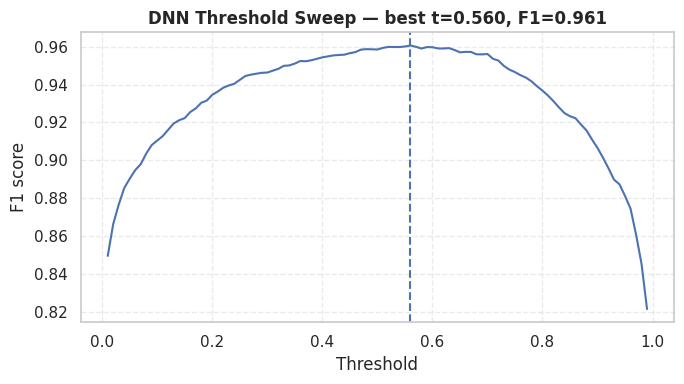

In [ ]:

if is_binary:
    ts = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_true, (dnn_probs >= t).astype(int)) for t in ts]
    best_idx = int(np.argmax(f1s))
    best_t, best_f1 = ts[best_idx], f1s[best_idx]

    plt.figure(figsize=(7,4))
    plt.plot(ts, f1s)
    plt.axvline(best_t, ls='--')
    plt.title(f"DNN Threshold Sweep — best t={best_t:.3f}, F1={best_f1:.3f}", fontweight='bold')
    plt.xlabel("Threshold"); plt.ylabel("F1 score"); plt.grid(True, ls='--', alpha=0.4)
    plt.tight_layout(); plt.show()


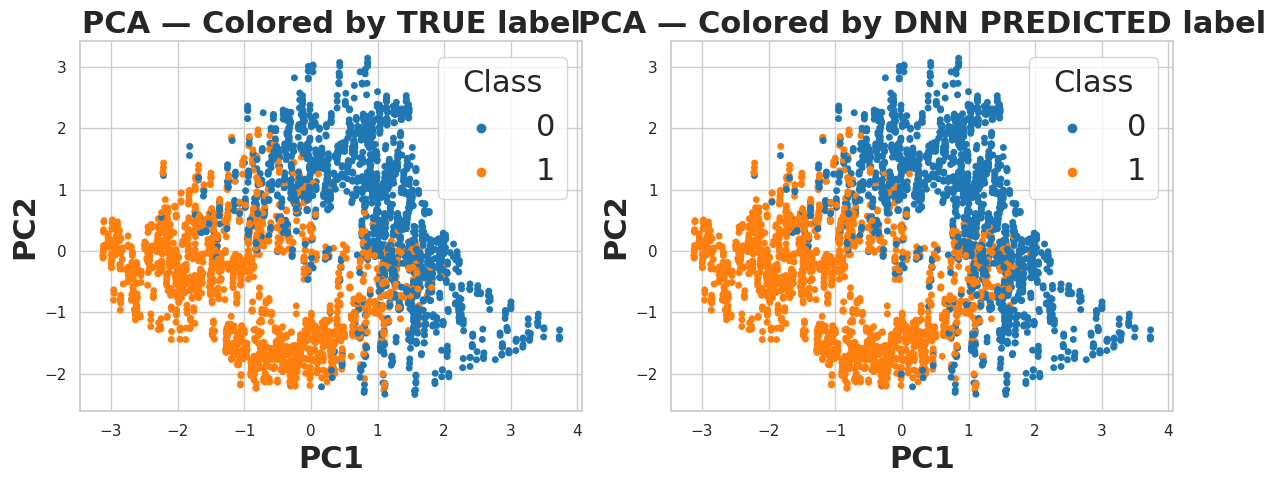

In [23]:
pca = PCA(n_components=2, random_state=42).fit(X_test_scaled)
Z = pca.transform(X_test_scaled)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=y_true, ax=axes[0], palette="tab10", s=25, edgecolor='none')
axes[0].set_title("PCA — Colored by TRUE label", fontsize=22, fontweight='bold')
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=dnn_preds, ax=axes[1], palette="tab10", s=25, edgecolor='none')
axes[1].set_title("PCA — Colored by DNN PREDICTED label", fontsize=22, fontweight='bold')
for ax in axes: 
    ax.set_xlabel("PC1", fontsize=22, fontweight='bold')
    ax.set_ylabel("PC2", fontsize=22, fontweight='bold')
    ax.legend(title="Class", fontsize=22, title_fontsize=22)
plt.tight_layout()
plt.show()

The figure layout has changed to tight


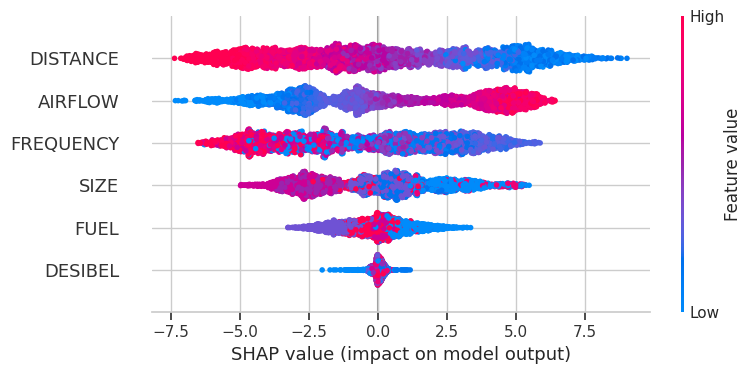

In [ ]:

if _has_shap:
    try:
        shap.initjs()
        bg_idx = np.random.choice(X_train.shape[0], size=min(200, X_train.shape[0]), replace=False)
        explainer = shap.TreeExplainer(xgb_model)
        shap_values = explainer.shap_values(X_test)

        plt.figure()
        if isinstance(shap_values, list):  
            shap.summary_plot(shap_values, X_test, show=False)
        else:  
            shap.summary_plot(shap_values, X_test, show=False)
        plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"SHAP skipped due to: {e}")
else:
    print("SHAP not available in this environment — skipping.")

In [ ]:

def _bin_metrics(y, p, name):
    yhat = (p >= 0.5).astype(int)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y, yhat),
        "F1": f1_score(y, yhat),
        "AUC-ROC": auc(*roc_curve(y, p)[:2]),
        "AUC-PR": average_precision_score(y, p)
    }

if is_binary:
    metrics_df = pd.DataFrame([
        _bin_metrics(y_true, rf_probs,  "RF"),
        _bin_metrics(y_true, xgb_probs, "XGB"),
        _bin_metrics(y_true, dnn_probs, "DNN"),
    ]).round(4)
    display(metrics_df)

,Model,Accuracy,F1,AUC-ROC,AUC-PR
0,RF,0.9642,0.9639,0.9945,0.9942
1,XGB,0.9785,0.9783,0.9978,0.9978
2,DNN,0.9587,0.9586,0.9942,0.9943
